# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [178]:
import os
from tqdm import tqdm
import pandas as pd

import selfies as sf
from rdkit import Chem
from rdkit.Chem import Descriptors

import torch
import torch.nn.functional as F

from src.selfies import SelfiesEncoder
from src.vae import MolecularVAE
from src.train import train_vae
from src.utils import compute_logp

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

# Preprocessing

Download raw dataset:

In [7]:
dataset_url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"

raw_df = pd.read_csv(dataset_url)
raw_df.to_csv(os.path.join("data", "qm9_raw.csv"), index=False)

Add selfies encoding to raw data:

In [183]:
def compute_logp(smile: str) -> float:
    mol = Chem.MolFromSmiles(smile)
    return Descriptors.MolLogP(mol)

In [6]:
df = pd.read_csv(os.path.join("data", "qm9_raw.csv"))

df["selfies"] = [sf.encoder(x, strict=False) for x in df.smiles]
df["logp"] = [compute_logp(s) for s in df.smiles]
df = df[["mol_id", "smiles", "selfies", "mu", "alpha", "homo", "lumo", "gap", "r2", "logp"]]

df.to_csv(os.path.join("data", "qm9_processed.csv"), index=False)

Generate one-hot enocding for selfies strings:

In [35]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))
df.head()

,mol_id,smiles,selfies,mu,alpha,homo,lumo,gap,r2,logp
0,gdb_1,C,[C],0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.63610
1,gdb_2,N,[N],1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,0.16200
2,gdb_3,O,[O],1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,-0.82470
3,gdb_4,C#C,[C][#C],0.0000,16.28,-0.2845,0.0506,0.3351,59.5248,0.24940
4,gdb_5,C#N,[C][#N],2.8937,12.99,-0.3604,0.0191,0.3796,48.7476,0.13978


In [36]:
selfies = df.selfies
selfies_encoder = SelfiesEncoder.build(selfies)

In [9]:
one_hots = []
for s in tqdm(selfies):
    one_hots.append(selfies_encoder.encode_one_hot(s))
one_hots = torch.tensor(one_hots)
torch.save(one_hots, os.path.join(data_path, "qm9_encodings.pt"))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 133885/133885 [00:03<00:00, 34270.27it/s]


NameError: name 'data_path' is not defined

# VAE

## Training

In [16]:
torch.manual_seed(42)
device = device = 'cuda' if torch.cuda.is_available() else 'cpu'

x = torch.load(os.path.join("data", "qm9_encodings.pt"))
x = x.float().to(device)
full_dataset =  torch.utils.data.TensorDataset(x)

test_frac = 0.1
test_size = int(test_frac * len(x))
train_size = len(x) - test_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [17]:
batch_size = 250

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [18]:
model = MolecularVAE()
model.to(device)

print(f"# Parameters = {model.n_parameters()}")
model

# Parameters = 3927585


MolecularVAE(
  (encoder_conv): Sequential(
    (0): Conv1d(29, 9, kernel_size=(9,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(9, 9, kernel_size=(9,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(9, 10, kernel_size=(10,), stride=(1,), padding=(2,))
    (5): ReLU()
  )
  (encoder_linear): Sequential(
    (0): Linear(in_features=80, out_features=400, bias=True)
    (1): SELU()
  )
  (encoder_mean): Linear(in_features=400, out_features=50, bias=True)
  (encoder_logvar): Linear(in_features=400, out_features=50, bias=True)
  (decoder_linear): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): SELU()
  )
  (decoder_gru): GRU(50, 500, num_layers=3, batch_first=True)
  (decoder_output): Linear(in_features=500, out_features=29, bias=True)
)

In [19]:
learning_rate = 2e-3
weight_decay = 1e-5

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay,
)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)

In [20]:
n_epochs = 150

tracker = train_vae(
    model, 
    optimizer, 
    scheduler,
    train_loader, 
    test_loader,
    n_epochs=n_epochs,
    print_every=1
)

Epoch 1 | Train Loss = 26.2799 | Test loss = 25.2600 | Train Accuracy = 0.0000 | Test Accuracy = 0.0000 | LR = 2.000e-03
Epoch 2 | Train Loss = 21.9898 | Test loss = 20.0116 | Train Accuracy = 0.0001 | Test Accuracy = 0.0002 | LR = 2.000e-03
Epoch 3 | Train Loss = 19.4302 | Test loss = 18.4302 | Train Accuracy = 0.0002 | Test Accuracy = 0.0004 | LR = 2.000e-03
Epoch 4 | Train Loss = 17.1859 | Test loss = 15.5679 | Train Accuracy = 0.0005 | Test Accuracy = 0.0008 | LR = 2.000e-03
Epoch 5 | Train Loss = 15.5455 | Test loss = 13.8310 | Train Accuracy = 0.0012 | Test Accuracy = 0.0028 | LR = 2.000e-03
Epoch 6 | Train Loss = 12.3397 | Test loss = 10.7209 | Train Accuracy = 0.0057 | Test Accuracy = 0.0117 | LR = 2.000e-03
Epoch 7 | Train Loss = 10.5201 | Test loss = 9.5444 | Train Accuracy = 0.0141 | Test Accuracy = 0.0205 | LR = 2.000e-03
Epoch 8 | Train Loss = 8.5782 | Test loss = 8.0611 | Train Accuracy = 0.0281 | Test Accuracy = 0.0343 | LR = 2.000e-03
Epoch 9 | Train Loss = 7.2826 | Tes

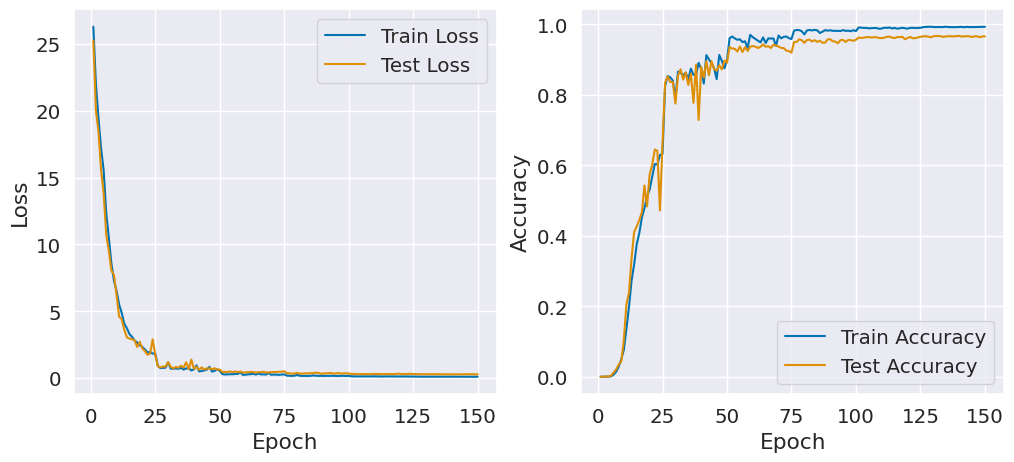

In [22]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))

train_loss = tracker.get_metric("train_loss")
test_loss = tracker.get_metric("test_loss")
train_accuracy = tracker.get_metric("train_accuracy")
test_accuracy = tracker.get_metric("test_accuracy")

ax[0].plot(train_loss[:,0], train_loss[:,1], label='Train Loss')
ax[0].plot(test_loss[:,0], test_loss[:,1], label='Test Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_accuracy[:,0], train_accuracy[:,1], label='Train Accuracy')
ax[1].plot(test_accuracy[:,0], test_accuracy[:,1], label='Test Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.savefig(os.path.join("models", f"vae_epochs_{n_epochs}.png"))

plt.show()

In [ ]:
# torch.save(model.state_dict(), os.path.join("models", f"vae_epochs_{n_epochs}.pt"))

## Visualization

In [233]:
model_path = os.path.join("models", f"vae_epochs_150.pt")
model_params = torch.load(model_path)

trained_model = MolecularVAE()
trained_model.load_state_dict(model_params)

trained_model.eval()

MolecularVAE(
  (encoder_conv): Sequential(
    (0): Conv1d(29, 9, kernel_size=(9,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(9, 9, kernel_size=(9,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(9, 10, kernel_size=(10,), stride=(1,), padding=(2,))
    (5): ReLU()
  )
  (encoder_linear): Sequential(
    (0): Linear(in_features=80, out_features=400, bias=True)
    (1): SELU()
  )
  (encoder_mean): Linear(in_features=400, out_features=50, bias=True)
  (encoder_logvar): Linear(in_features=400, out_features=50, bias=True)
  (decoder_linear): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): SELU()
  )
  (decoder_gru): GRU(50, 500, num_layers=3, batch_first=True)
  (decoder_output): Linear(in_features=500, out_features=29, bias=True)
)

In [238]:
xs = x[10:20].cpu()

x_recon, _, _ = trained_model(xs)

actual_selfies = selfies_encoder.decode_tensor(xs)
decoded_selfies = selfies_encoder.decode_tensor(x_recon)

In [239]:
actual_smiles = [sf.decoder(s) for s in actual_selfies]
decoded_smiles = [sf.decoder(s) for s in decoded_selfies]

In [240]:
actual_mols = [Chem.MolFromSmiles(s) for s in actual_smiles]
decoded_mols = [Chem.MolFromSmiles(s) for s in decoded_smiles]

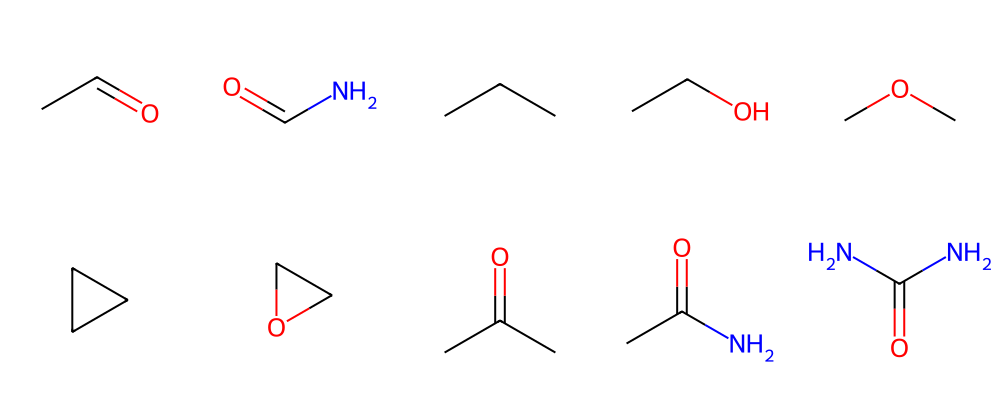

In [241]:
Chem.Draw.MolsToGridImage(actual_mols, molsPerRow=5)

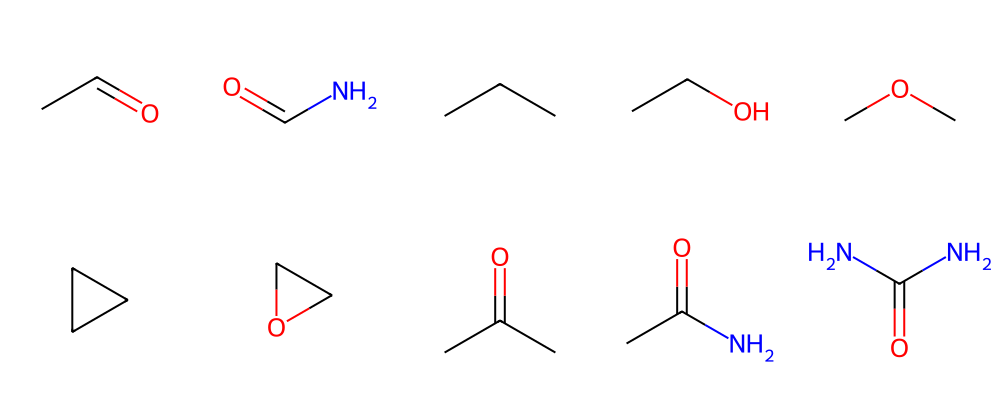

In [242]:
Chem.Draw.MolsToGridImage(decoded_mols, molsPerRow=5)

In [243]:
import umap

In [245]:
xs = x[::50].cpu()

sample_selfies = selfies_encoder.decode_tensor(xs)
sample_mols = [Chem.MolFromSmiles(sf.decoder(s)) for s in sample_selfies]

sample_descriptors = [Descriptors.ExactMolWt(m) for m in sample_mols]

In [247]:
latent_vectors = trained_model.encode(xs)[0]
latent_vectors = latent_vectors.detach().numpy()

latent_reduced = umap.UMAP().fit_transform(latent_vectors)

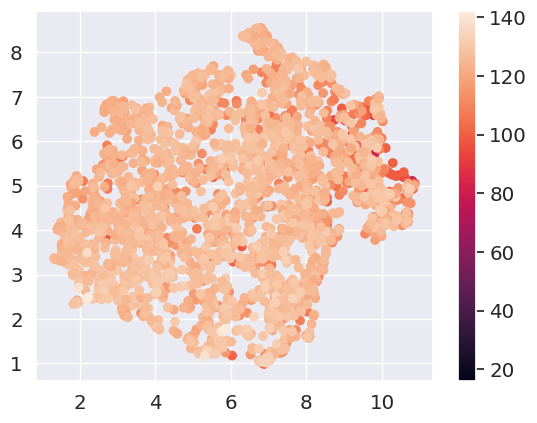

In [248]:
sc = plt.scatter(latent_reduced[:,0], latent_reduced[:,1], c=sample_descriptors)
plt.colorbar(sc)

plt.show()

# Flory

In [5]:
n_components = 2
objective = FloryHuggins(n_components)
objective.set_size(0, 1)
objective.set_pairwise(0, 1, 3.0)

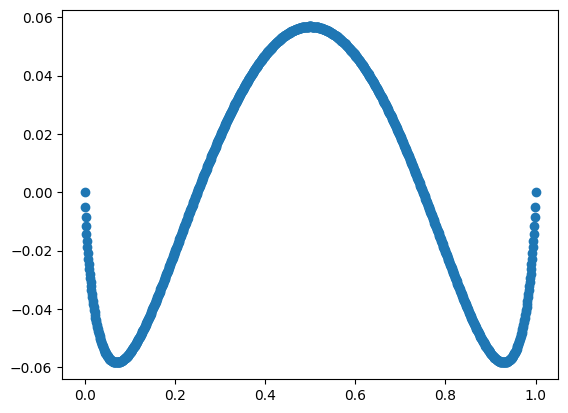

In [6]:
n = 1000

x0 = torch.linspace(0.0, 1.0, n)
x1 = 1.0 - x0

x = torch.stack([x0, x1], dim=1)
y = objective(x)

plt.scatter(x[:,1], y)
plt.show()